In [130]:
%matplotlib inline
import data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [131]:
idd, seq = data.readseq('train.csv')

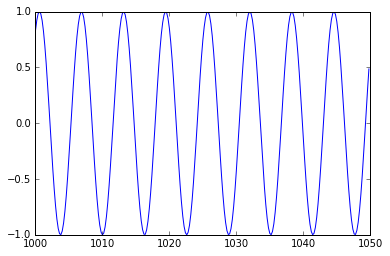

In [132]:
x = np.arange(1000, 1050, step=0.2)
y = np.sin(x)
plt.plot(x, y)
plt.show()

In [133]:
def get_batch(s, ix):
    t = s[ix]
    return t[:-1], t[1:]
def sine_data(ix,size=50):
    x = np.arange(ix, ix + size, step = 0.2)
    y = np.sin(x)
    return y[:-1], y[1:]

In [155]:
inp_out_size = 1
hidden_layer_size = 5
lr = 0.001
epoch = 5000
print_step = 200
num_steps = 15

In [156]:
tf.reset_default_graph()
Wxh = tf.Variable(tf.random_uniform([inp_out_size, hidden_layer_size], maxval=0.01, minval=-0.01), dtype=tf.float32)
Whh = tf.Variable(tf.random_uniform([hidden_layer_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
Why = tf.Variable(tf.random_uniform([hidden_layer_size, inp_out_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
# weights associated with update gate
Wxz = tf.Variable(tf.random_uniform([inp_out_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
Whz = tf.Variable(tf.random_uniform([hidden_layer_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
# weights associated with the reset gate
Wxr = tf.Variable(tf.random_uniform([inp_out_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
Whr = tf.Variable(tf.random_uniform([hidden_layer_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)

In [157]:
def GRU(prev, inp):
    i = tf.reshape(inp, shape=[1, -1])
    p = tf.reshape(prev, shape=[1, -1])
    z = tf.nn.sigmoid(tf.matmul(i, Wxz) + tf.matmul(p, Whz))    # update gate
    r = tf.nn.sigmoid(tf.matmul(i, Wxr) + tf.matmul(p, Whr))    # reset gate
    h_ = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(tf.mul(p, r), Whh))
#     h = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(p, Whh))
    h = tf.mul(tf.sub(tf.ones_like(z), z), h_) + tf.mul(z, p)
    return tf.reshape(h, [hidden_layer_size])

In [158]:
# model
inputs = tf.placeholder(shape=[None, 1], dtype=tf.float32)
targets = tf.placeholder(shape=[None, 1], dtype=tf.float32)
initial = tf.placeholder(shape=[hidden_layer_size], dtype=tf.float32)
hiddens = tf.scan(GRU, inputs, initializer=initial)
outputs = tf.matmul(hiddens, Why)
loss = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(outputs, targets))))
optimizer = tf.train.GradientDescentOptimizer(lr)
# grad = optimizer.compute_gradients(loss, [Wxh])[0][0]
optimize_op = optimizer.minimize(loss)

In [159]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [160]:
ix = 0
ini = np.zeros([hidden_layer_size])

In [161]:
for i in range(epoch):
    a, b = sine_data(ix, size=num_steps)    
    a = np.reshape(a, [-1, 1])
    b = np.reshape(b, [-1, 1])
    l, h, _ = sess.run([loss, hiddens, optimize_op], {inputs: a, targets: b, initial: ini})
    ix += 1
    if i % print_step == 0:
        print('Loss', l)
    ix += num_steps
    ini = h[-1]

Loss 6.2055
Loss 5.91555
Loss 6.19818
Loss 5.75807
Loss 4.2914
Loss 2.47355
Loss 2.2591
Loss 2.17504
Loss 2.00838
Loss 1.95546
Loss 1.84477
Loss 1.76718
Loss 1.70627
Loss 1.64217
Loss 1.59444
Loss 1.52806
Loss 1.46597
Loss 1.37183
Loss 1.30534
Loss 1.1306
Loss 0.946474
Loss 0.624982
Loss 0.258327
Loss 0.379053
Loss 0.338312


In [162]:
def generate(sess, n):
    ix = [[0.2]]
    v = []
    h = np.zeros(hidden_layer_size)
    for i in range(n):
        o, h = sess.run([outputs, hiddens], {inputs:ix, initial: h})
        h = h.reshape(hidden_layer_size)
        ix = o
        v.append(np.squeeze(o))
    return v

(199,) (250,)


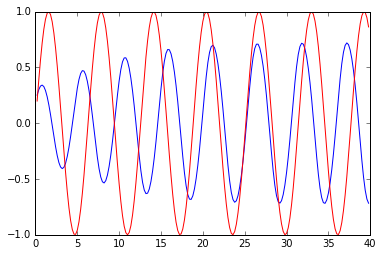

In [163]:
x = np.arange(0.2, 40, step = 0.2)
pred = np.array(generate(sess, len(x)))
true = np.sin(x)
print(x.shape, y.shape)
plt.plot(x, pred, 'b-')
plt.plot(x, true, 'r-')
plt.show()